# 28. cGAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 28.1 Prepare MNIST Data

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

In [4]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transform,
                          download=True)

In [5]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

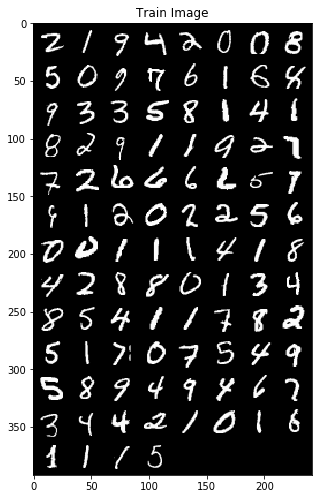

In [7]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 28.2 Define Model

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        
        self.label_layer = nn.Linear(10, 256)
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7 + 256, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()        
        )
        
    def forward(self, x, label):
        
        out = self.discriminator(x)
        out_img = out.view(-1, 64*7*7)
        out_label = self.label_layer(label)
        
        out = self.fc_layer(torch.cat([out_img, out_label], dim = 1))
        
        return out

In [9]:
D = Discriminator().cuda()

In [10]:
D(torch.rand(100, 1, 28, 28).cuda(), torch.rand(100, 10).cuda()).shape

torch.Size([100, 1])

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
               
        self.latent_layer = nn.Linear(100, 256)
        self.label_layer = nn.Linear(10, 256)
        self.fc_layer = nn.Linear(256 + 256, 64*7*7)
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z, label):
        
        out_z = self.latent_layer(z)
        out_label = self.label_layer(label)
        
        out = self.fc_layer(torch.cat([out_z, out_label], dim = 1))
        out = out.view(-1, 64, 7, 7)
        out = self.generator(out)
        return out

In [12]:
G = Generator().cuda()

In [13]:
G(torch.rand(100, 100).cuda(), torch.rand(100, 10).cuda()).shape

torch.Size([100, 1, 28, 28])

## 28.3 Train Model

In [14]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, target_tensor.cuda())

In [15]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [16]:
num_epochs = 20

In [17]:
one_hot_labels = torch.eye(10)

In [18]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
        labels = one_hot_labels[labels].cuda()
        
        prob_real = D(images, labels)
        D_loss_real = gan_loss(prob_real, True)

        z = torch.randn((batch_size, 100)).cuda()
        fake_images = G(z, labels)
        
        prob_fake = D(fake_images, labels)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = torch.randn((batch_size, 100)).cuda()
        fake_images = G(z, labels)
        
        prob_fake = D(fake_images, labels)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/20], lter [100/600], D_Loss: 0.0659, G_Loss: 5.8108
Epoch [1/20], lter [200/600], D_Loss: 0.2280, G_Loss: 5.1640
Epoch [1/20], lter [300/600], D_Loss: 0.0106, G_Loss: 6.3507
Epoch [1/20], lter [400/600], D_Loss: 0.0610, G_Loss: 4.9702
Epoch [1/20], lter [500/600], D_Loss: 0.0419, G_Loss: 5.9355
Epoch [1/20], lter [600/600], D_Loss: 0.1034, G_Loss: 7.4633
Epoch [2/20], lter [100/600], D_Loss: 0.0134, G_Loss: 6.9136
Epoch [2/20], lter [200/600], D_Loss: 0.1304, G_Loss: 7.3541
Epoch [2/20], lter [300/600], D_Loss: 0.0497, G_Loss: 7.0786
Epoch [2/20], lter [400/600], D_Loss: 0.0802, G_Loss: 5.1806
Epoch [2/20], lter [500/600], D_Loss: 0.0895, G_Loss: 5.7370
Epoch [2/20], lter [600/600], D_Loss: 0.0255, G_Loss: 6.5287
Epoch [3/20], lter [100/600], D_Loss: 0.0673, G_Loss: 4.7507
Epoch [3/20], lter [200/600], D_Loss: 0.0409, G_Loss: 6.2143
Epoch [3/20], lter [300/600], D_Loss: 0.0342, G_Loss: 5.3978
Epoch [3/20], lter [400/600], D_Loss: 0.0648, G_Loss: 4.1665
Epoch [3/20], lter [500/

## 28.4 Test Model

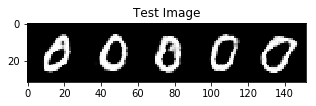

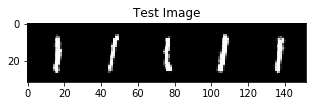

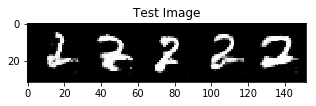

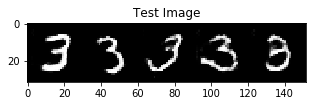

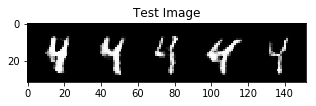

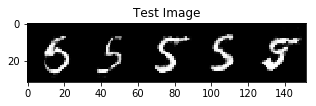

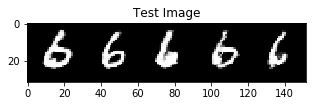

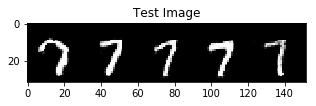

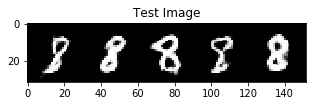

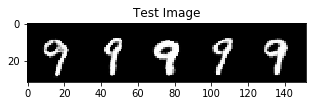

In [19]:
G.eval()

for i in range(10) :
    z = torch.randn((5, 100)).cuda()
    images = G(z, one_hot_labels[[i]*5].cuda())
    imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")